In [2]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sqlalchemy import create_engine
from urllib.parse import quote_plus

## 1- Connecting and loading Chinook database

In [3]:
with open('../db_config.json', 'r') as config_file:
    db_config = json.load(config_file)

In [4]:
encoded_password = quote_plus(db_config['password'])
engine = create_engine(
    f"mysql+mysqlconnector://{db_config['user']}:{encoded_password}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
)

In [5]:
album = pd.read_sql(f"SELECT * FROM album", engine)
artist = pd.read_sql(f"SELECT * FROM artist", engine)
customer = pd.read_sql(f"SELECT * FROM customer", engine)
employee = pd.read_sql(f"SELECT * FROM employee", engine)
genre = pd.read_sql(f"SELECT * FROM genre", engine)
invoice = pd.read_sql(f"SELECT * FROM invoice", engine)
invoiceLine = pd.read_sql(f"SELECT * FROM invoiceLine", engine)
mediaType = pd.read_sql(f"SELECT * FROM mediaType", engine)
playlist = pd.read_sql(f"SELECT * FROM playlist", engine)
playlistTrack = pd.read_sql(f"SELECT * FROM playlistTrack", engine)
track = pd.read_sql(f"SELECT * FROM track", engine)

engine.dispose()

In [6]:
tables = {"album": album,
          "artist": artist,
          "customer": customer,
          "employee": employee,
          "genre": genre,
          "invoice": invoice,
          "invoiceLine": invoiceLine,
          "mediaType": mediaType,
          "playlist": playlist,
          "playlistTrack": playlistTrack,
          "track": track}

In [7]:
output_directory = r'..\data\processed'
   
for df_name, df in tables.items():
        df.to_csv(f"{output_directory}\\{df_name}.csv", index=False)

## 2- Initial review

In [8]:
for name, table in tables.items():
    print(f"{name} table shape: {table.shape}")

album table shape: (347, 3)
artist table shape: (275, 2)
customer table shape: (59, 13)
employee table shape: (8, 15)
genre table shape: (25, 2)
invoice table shape: (412, 9)
invoiceLine table shape: (2240, 5)
mediaType table shape: (5, 2)
playlist table shape: (18, 2)
playlistTrack table shape: (8715, 2)
track table shape: (3503, 9)


In [9]:
for name, table in tables.items():
    print(table.info())
    print("\n" + "="*40 + "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   AlbumId   347 non-null    int64 
 1   Title     347 non-null    object
 2   ArtistId  347 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.3+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ArtistId  275 non-null    int64 
 1   Name      275 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.4+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerId    59 non-null     int64 
 1   FirstName     59 non-null     object
 2   LastName      59 non-null     object
 3   Company       10 n

## 3- Distribution of Key Variables 

Total amount spent by customers

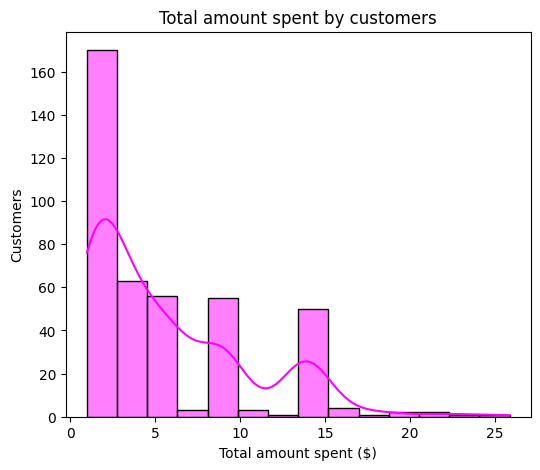

In [85]:
plt.figure(figsize=(6,5))
sns.histplot(invoice['Total'], kde=True, color='fuchsia')
plt.xlabel("Total amount spent ($)")
plt.ylabel("Customers")
plt.title("Total amount spent by customers")

plt.show()

Quantity of each track purchased

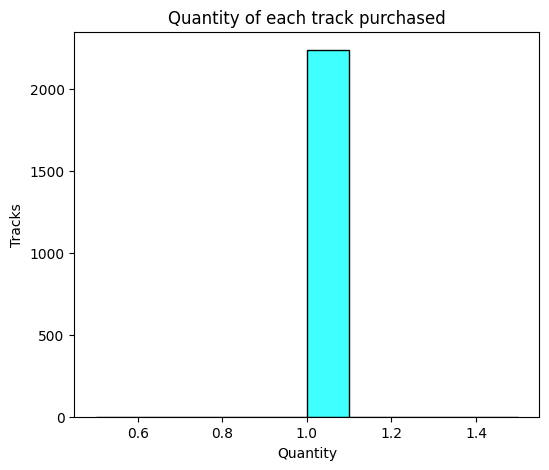

In [83]:
plt.figure(figsize=(6,5))
sns.histplot(invoiceLine['Quantity'], bins=10, color='cyan')
plt.xlabel("Quantity")
plt.ylabel("Tracks")
plt.title("Quantity of each track purchased")

plt.show()

The customers only ordered one of the same track in each purchase.

Price of each track purchased

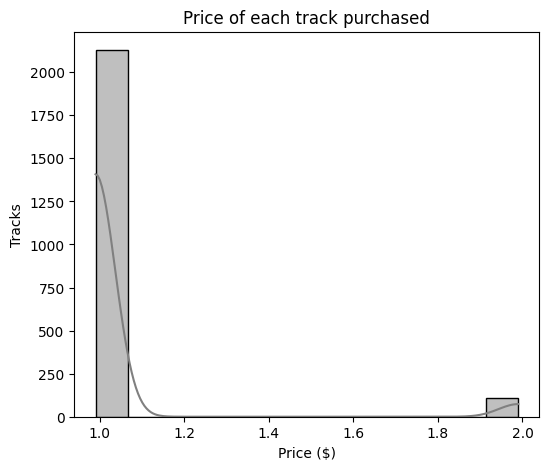

In [82]:
plt.figure(figsize=(6,5))
sns.histplot(invoiceLine['UnitPrice'], kde=True, color='grey')
plt.xlabel("Price ($)")
plt.ylabel("Tracks")
plt.title("Price of each track purchased")

plt.show()

Size of each track

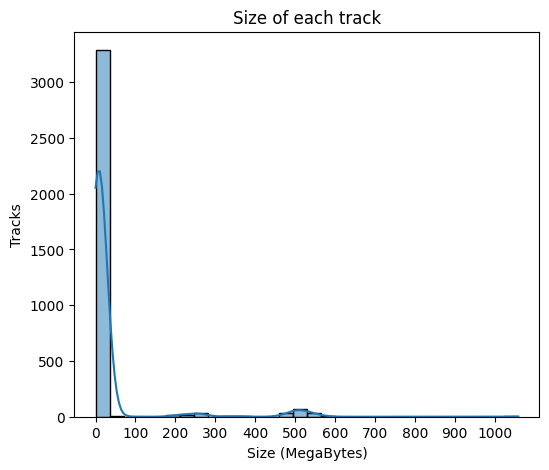

In [81]:
plt.figure(figsize=(6,5))
sns.histplot(track['Bytes']/1000000, kde=True, bins= 30)
plt.xlabel("Size (MegaBytes)")
plt.ylabel("Tracks")
plt.title("Size of each track")

xticks = np.arange(0, 1001, 100)
plt.xticks(xticks)
plt.show()

Duration of each track

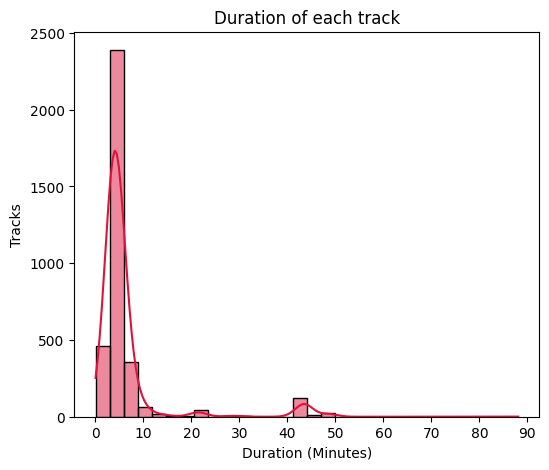

In [76]:
plt.figure(figsize=(6,5))
sns.histplot(track['Milliseconds']/60000, kde=True, bins= 30, color='crimson')
plt.xlabel("Duration (Minutes)")
plt.ylabel("Tracks")
plt.title("Duration of each track")

xticks = np.arange(0, 91, 10)
plt.xticks(xticks)
plt.show()

Price of each track

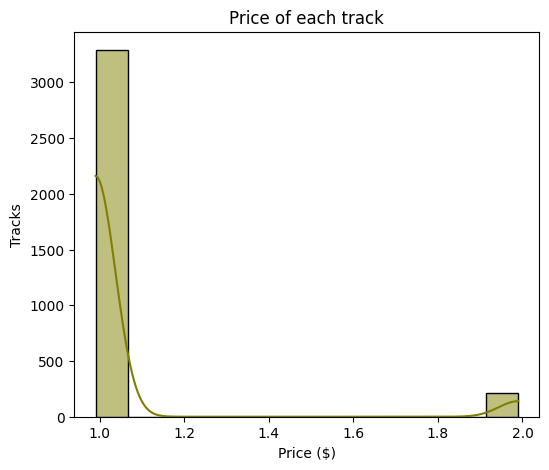

In [74]:
plt.figure(figsize=(6,5))
sns.histplot(track['UnitPrice'], kde=True, color='olive')
plt.xlabel("Price ($)")
plt.ylabel("Tracks")
plt.title("Price of each track")

plt.show()

## 4- Understanding data with plotting

Distribution of Customers by Support Representative

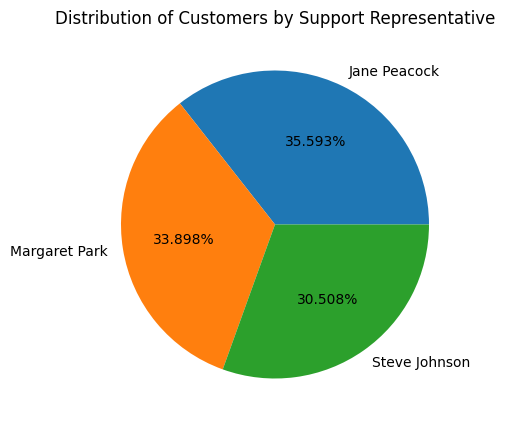

In [16]:
# Creating a column for the employee's full name
employee['FullName'] = employee['FirstName'] + " " + employee['LastName']

support_rep_count = customer.groupby('SupportRepId')['CustomerId'].agg('count').reset_index(name='Count')
sample_employees = employee[employee['EmployeeId'].isin(support_rep_count['SupportRepId'])]

plt.figure(figsize=(6,5))
plt.pie(support_rep_count['Count'], labels=sample_employees['FullName'], autopct='%1.3f%%')
plt.title("Distribution of Customers by Support Representative")

plt.show()

The customers were distrebuted between employees almost at the same rate but mostly **Jane Peacock** with total 21 customers.

Distribution of Genres in Chinook Database

In [17]:
genre_merged_track = pd.merge(track, genre, on='GenreId', suffixes=['_track','_genre'])
genre_count = genre_merged_track.groupby(['GenreId','Name_genre'])['TrackId'].agg('count').reset_index(name='Count')
genre_count['Percentage'] = ((genre_count['Count'] / genre_count['Count'].sum()) * 100).round(2)

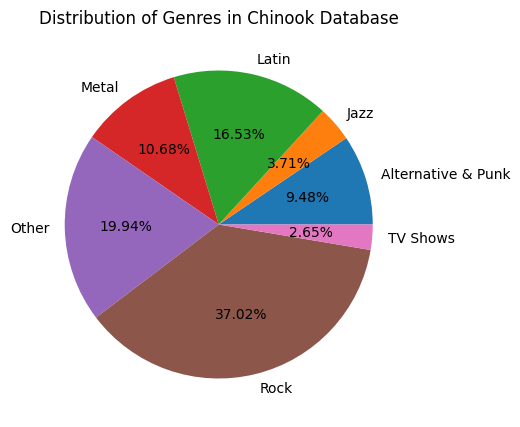

In [18]:
genre_count['labels_combined'] = genre_count['Name_genre'].where(genre_count['Percentage'] >= 2.5, 'Other')
genre_count_combined = genre_count.groupby('labels_combined', as_index=False)['Percentage'].agg('sum')

plt.figure(figsize=(6,5))
plt.pie(genre_count_combined['Percentage'], labels=genre_count_combined['labels_combined'], autopct='%1.2f%%')
plt.title("Distribution of Genres in Chinook Database")

plt.show()

Between 25 genres, Most tracks are **Rock, Latin and Metal**.

Distribution of Media Types in Chinook Database

In [19]:
mediaType_merged_track = pd.merge(track, mediaType, on='MediaTypeId', suffixes=['_track','_mediaType'])
mediaType_count = mediaType_merged_track.groupby(['MediaTypeId','Name_mediaType'])['TrackId'].agg('count').reset_index(name='Count')
mediaType_count['Percentage'] = ((mediaType_count['Count'] / mediaType_count['Count'].sum()) * 100).round(2)

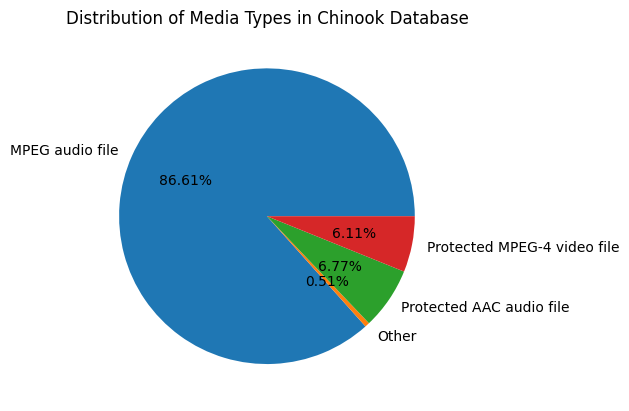

In [20]:
mediaType_count['labels_combined'] = mediaType_count['Name_mediaType'].where(mediaType_count['Percentage'] >= 5, 'Other')
mediaType_count_combined = mediaType_count.groupby('labels_combined', as_index=False)['Percentage'].agg('sum')

plt.pie(mediaType_count_combined['Percentage'], labels=mediaType_count_combined['labels_combined'], autopct='%1.2f%%')
plt.title("Distribution of Media Types in Chinook Database")

plt.show()

Most tracks are formatted as **MPEG audio file** with total of **3034**.

Distribution of Tracks per Album

In [21]:
tracks_per_album = track.groupby('AlbumId')['TrackId'].agg('count').reset_index(name='Count')
avg_tracks_per_album = np.mean(tracks_per_album['Count'])
print(f"The average number of tracks per album is {round(avg_tracks_per_album)}.")

The average number of tracks per album is 10.


In [22]:
q1 = np.percentile(tracks_per_album['Count'], 25)
q2 = np.percentile(tracks_per_album['Count'], 50)
q3 = np.percentile(tracks_per_album['Count'], 75)
print(f"50% of albums have {q1} to {q3} tracks.")

50% of albums have 2.0 to 14.0 tracks.


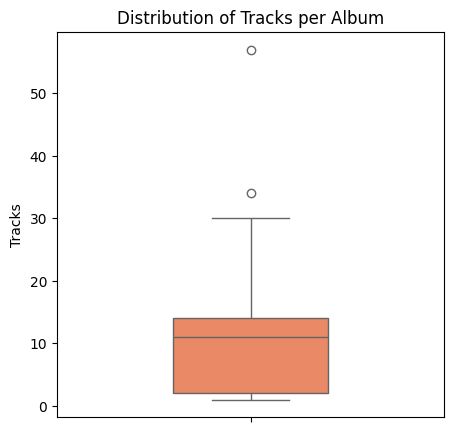

In [69]:
plt.figure(figsize=(5,5))
sns.boxplot(tracks_per_album['Count'], width=0.4, color='coral')
plt.ylabel("Tracks")
plt.title("Distribution of Tracks per Album")

plt.show()

## 5- Checking Normality of key variables

Total amount spent by customers

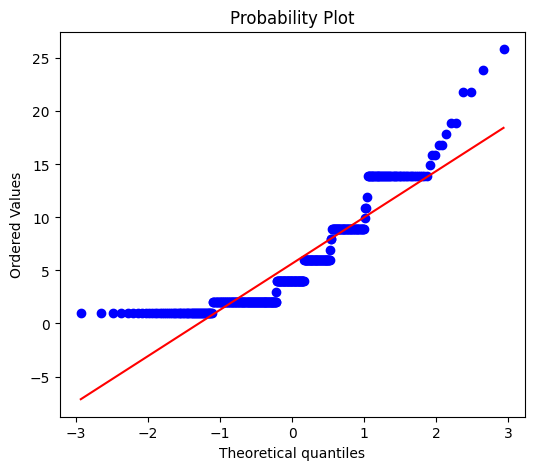

In [24]:
# QQ plot of Total amount spent by customers

plt.figure(figsize=(6,5))
stats.probplot(invoice['Total'], dist="norm", plot=plt)

plt.show()

In [25]:
# Shapiro-Wilk test for Total amount spent by customers

# Null hypothesis: The Total amount spent by customers is normally distributed.
# Alternative hypothesis: The Total amount spent by customers is not normally distributed.


statistic_invoice_total, p_value_invoice_total = stats.shapiro(invoice['Total'])
print(f"Shapiro-Wilk Test for Total amount spent by customers: Statistic = {statistic_invoice_total}, p-value = {p_value_invoice_total}")

alpha = 0.05
if p_value_invoice_total < alpha:
    print("Reject the null hypothesis, The Total amount spent by customers is not normally distributed.")
else:
    print("Fail to reject the null hypothesis, indicating that the data is normally distributed.")

Shapiro-Wilk Test for Total amount spent by customers: Statistic = 0.8367111017894937, p-value = 3.4001843897448504e-20
Reject the null hypothesis, The Total amount spent by customers is not normally distributed.


Price of each track purchased

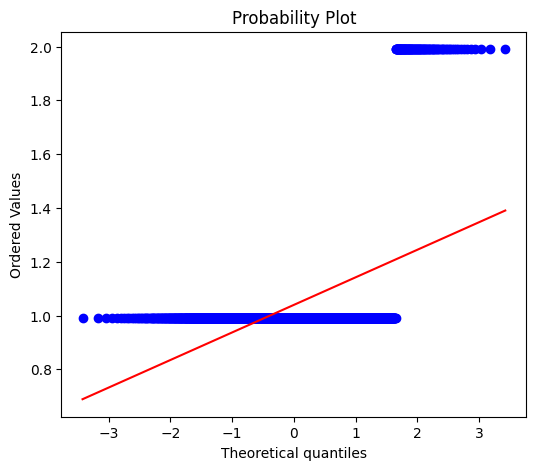

In [26]:
# QQ plot for Price of each track purchased

plt.figure(figsize=(6,5))
stats.probplot(invoiceLine['UnitPrice'], dist="norm", plot=plt)

plt.show()

In [27]:
# Shapiro-Wilk test for the Price of each track purchased

# Null hypothesis: The Price of each track purchased is normally distributed.
# Alternative hypothesis: The Price of each track purchased is not normally distributed.


statistic_invoiceline_price, p_value_invoiceline_price = stats.shapiro(invoiceLine['UnitPrice'])
print(f"Shapiro-Wilk Test for Price of each track purchased: Statistic = {statistic_invoiceline_price}, p-value = {p_value_invoiceline_price}")

alpha = 0.05
if p_value_invoiceline_price < alpha:
    print("Reject the null hypothesis, The Price of each track purchased is not normally distributed.")
else:
    print("Fail to reject the null hypothesis, indicating that the data is normally distributed.")

Shapiro-Wilk Test for Price of each track purchased: Statistic = 0.22256856261663105, p-value = 2.1025064392269568e-70
Reject the null hypothesis, The Price of each track purchased is not normally distributed.


Duration of each track

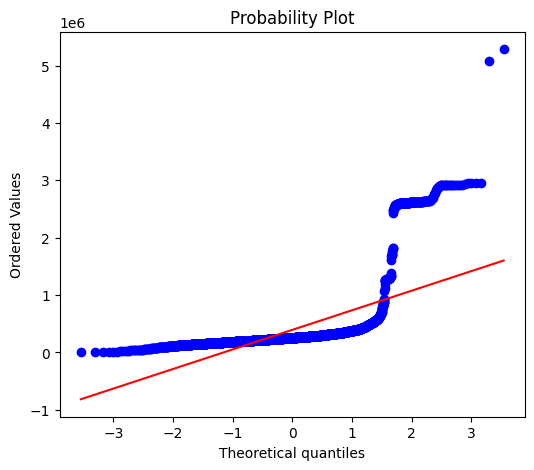

In [28]:
# QQ plot for Duration of each track

plt.figure(figsize=(6,5))
stats.probplot(track['Milliseconds'], dist="norm", plot=plt)

plt.show()

In [29]:
# Shapiro-Wilk test for Duration of each track

# Null hypothesis: The Duration of each track is normally distributed.
# Alternative hypothesis: The Duration of each track is not normally distributed.


statistic_track_duration, p_value_track_duration = stats.shapiro(track['Milliseconds'])
print(f"Shapiro-Wilk Test for Duration of each track: Statistic = {statistic_track_duration}, p-value = {p_value_track_duration}")

alpha = 0.05
if p_value_track_duration < alpha:
    print("Reject the null hypothesis, The Duration of each track is not normally distributed.")
else:
    print("Fail to reject the null hypothesis, indicating that the data is normally distributed.")

Shapiro-Wilk Test for Duration of each track: Statistic = 0.4069350980582944, p-value = 2.7287436202313686e-75
Reject the null hypothesis, The Duration of each track is not normally distributed.


Size of each track

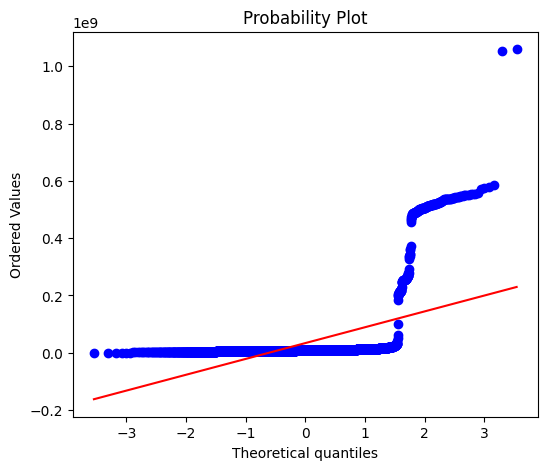

In [30]:
# QQ plot for Size of each track

plt.figure(figsize=(6,5))
stats.probplot(track['Bytes'], dist="norm", plot=plt)

plt.show()

In [31]:
# Shapiro-Wilk test for The Size of each track

# Null hypothesis: The Size of each track is normally distributed.
# Alternative hypothesis: The Size of each track is not normally distributed.


statistic_track_size, p_value_track_size = stats.shapiro(track['Bytes'])
print(f"Shapiro-Wilk Test for Size of each track: Statistic = {statistic_track_size}, p-value = {p_value_track_size}")

alpha = 0.05
if p_value_track_size < alpha:
    print("Reject the null hypothesis, The Size of each track is not normally distributed.")
else:
    print("Fail to reject the null hypothesis, indicating that the data is normally distributed.")

Shapiro-Wilk Test for Size of each track: Statistic = 0.2756405817618164, p-value = 1.7275565060666367e-79
Reject the null hypothesis, The Size of each track is not normally distributed.


Price of each track

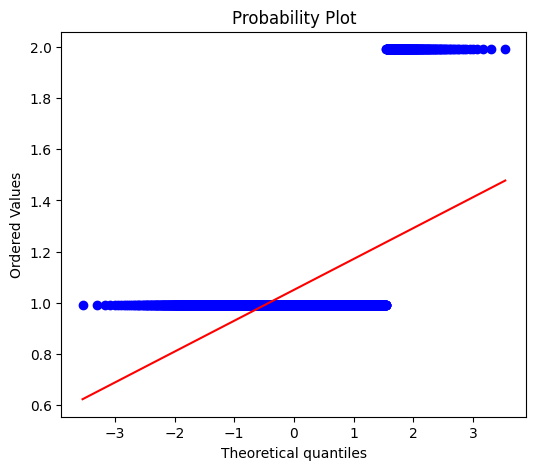

In [ ]:
# QQ plot Price of each track

plt.figure(figsize=(6,5))
stats.probplot(track['UnitPrice'], dist="norm", plot=plt)

plt.show()

In [33]:
# Shapiro-Wilk test for Price of each track

# Null hypothesis: The Price of each track is normally distributed.
# Alternative hypothesis: The Price of each track is not normally distributed.


statistic_track_price, p_value_track_price = stats.shapiro(track['UnitPrice'])
print(f"Shapiro-Wilk Test for Price of each track: Statistic = {statistic_track_price}, p-value = {p_value_track_price}")

alpha = 0.05
if p_value_track_price < alpha:
    print("Reject the null hypothesis, The Price of each track is not normally distributed.")
else:
    print("Fail to reject the null hypothesis, indicating that the data is normally distributed.")

Shapiro-Wilk Test for Price of each track: Statistic = 0.25366636273367993, p-value = 3.981126478782177e-80
Reject the null hypothesis, The Price of each track is not normally distributed.


I checked **Histogram, Q-Q Test and Shapiro Test for Normality**, and none of the key variables is normally distributed.

## 6- Finding and handling key variables outliers

First I want to define a function for finding the outliers.

In [34]:
def outliers(df, column):
    q1 = np.percentile(df[column], 25)
    q2 = np.percentile(df[column], 50)
    q3 = np.percentile(df[column], 75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    outlier = df[(df[column] < lower) | (df[column] > upper)]
    return outlier

Total amount spent by customers

In [35]:
outliers(invoice, 'Total')

,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total
95,96,45,2022-02-18,Erzsébet krt. 58.,Budapest,None,Hungary,H-1073,21.86
193,194,46,2023-04-28,3 Chatham Street,Dublin,Dublin,Ireland,None,21.86
298,299,26,2024-08-05,2211 W Berry Street,Fort Worth,TX,USA,76110,23.86
403,404,6,2025-11-13,Rilská 3174/6,Prague,None,Czech Republic,14300,25.86


Price of each track purchased

In [36]:
outliers(invoiceLine, 'UnitPrice')

,InvoiceLineId,InvoiceId,TrackId,UnitPrice,Quantity
467,468,87,2820,1.99,1
468,469,88,2826,1.99,1
469,470,88,2832,1.99,1
470,471,88,2838,1.99,1
471,472,88,2844,1.99,1
...,...,...,...,...,...
2196,2197,404,2895,1.99,1
2197,2198,404,2904,1.99,1
2198,2199,404,2913,1.99,1
2199,2200,404,2922,1.99,1


Duration of each track

In [37]:
outliers(track, 'Milliseconds')

,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
126,127,Stratus,13,1,2,Billy Cobham,582086,19115680,0.99
141,142,No More Tears,14,1,3,None,555075,18041629,0.99
153,154,Sleeping Village,16,1,3,None,644571,21128525,0.99
155,156,Wheels Of Confusion / The Straightener,17,1,3,"Tony Iommi, Bill Ward, Geezer Butler, Ozzy Osb...",494524,16065830,0.99
167,168,Now Sports,18,1,4,None,4884,161266,0.99
...,...,...,...,...,...,...,...,...,...
3444,3445,On the Beautiful Blue Danube,311,2,24,Johann Strauss II,526696,8610225,0.99
3445,3446,"Symphonie Fantastique, Op. 14: V. Songe d'une ...",312,2,24,Hector Berlioz,561967,9173344,0.99
3476,3477,Amy Amy Amy (Outro),322,2,9,"Astor Campbell, Delroy ""Chris"" Cooper, Donovan...",663426,10564704,0.99
3484,3485,Symphony No. 3 Op. 36 for Orchestra and Sopran...,330,2,24,Henryk Górecki,567494,9273123,0.99


Size of each track

In [38]:
outliers(track, 'Bytes')

,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
126,127,Stratus,13,1,2,Billy Cobham,582086,19115680,0.99
141,142,No More Tears,14,1,3,None,555075,18041629,0.99
153,154,Sleeping Village,16,1,3,None,644571,21128525,0.99
167,168,Now Sports,18,1,4,None,4884,161266,0.99
169,170,A Statistic,18,1,4,None,6373,211997,0.99
...,...,...,...,...,...,...,...,...,...
3363,3364,"There's No Place Like Home, Pt. 3",261,3,21,None,2582957,486161766,1.99
3401,3402,"Band Members Discuss Tracks from ""Revelations""",271,3,23,None,294294,61118891,0.99
3427,3428,Branch Closing,251,3,22,None,1814855,360331351,1.99
3428,3429,The Return,251,3,22,None,1705080,343877320,1.99


Price of each track

In [39]:
outliers(track, 'UnitPrice')

,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
2818,2819,Battlestar Galactica: The Story So Far,226,3,18,None,2622250,490750393,1.99
2819,2820,Occupation / Precipice,227,3,19,None,5286953,1054423946,1.99
2820,2821,"Exodus, Pt. 1",227,3,19,None,2621708,475079441,1.99
2821,2822,"Exodus, Pt. 2",227,3,19,None,2618000,466820021,1.99
2822,2823,Collaborators,227,3,19,None,2626626,483484911,1.99
...,...,...,...,...,...,...,...,...,...
3361,3362,"There's No Place Like Home, Pt. 1",261,3,21,None,2609526,522919189,1.99
3362,3363,"There's No Place Like Home, Pt. 2",261,3,21,None,2497956,523748920,1.99
3363,3364,"There's No Place Like Home, Pt. 3",261,3,21,None,2582957,486161766,1.99
3427,3428,Branch Closing,251,3,22,None,1814855,360331351,1.99


Given the high number of detected outliers, removing them could introduce bias and distort the true distribution of the data.

## 7- Hypothesis Testing

### 7-1) Find the three most popular genres and the difference between their distribution's average price.

In [40]:
invoiceLine_merged_track = pd.merge(invoiceLine, track)
invoiceLine_merged_track_merged_genre = pd.merge(invoiceLine_merged_track, genre, left_on='GenreId', right_on='GenreId', suffixes=['_track','_genre'])
genres_track_count = invoiceLine_merged_track_merged_genre.groupby(['GenreId','Name_genre'])['TrackId'].agg('count').reset_index(name='Count')
three_most_popular = genres_track_count.sort_values(by='Count', ascending=False).head(3)
three_most_popular

,GenreId,Name_genre,Count
0,1,Rock,835
6,7,Latin,386
2,3,Metal,264


In [41]:
rock_price = genre_merged_track[(genre_merged_track['GenreId'] == 1)]['UnitPrice']
metal_price = genre_merged_track[(genre_merged_track['GenreId'] == 3)]['UnitPrice']
latin_price = genre_merged_track[(genre_merged_track['GenreId'] == 7)]['UnitPrice']

rock_price_set = set(rock_price)
metal_price_set = set(metal_price)
latin_price_set = set(latin_price)


if (rock_price_set == metal_price_set) & (metal_price_set == latin_price_set):
    print(f"All three most popluar genres have the same price for each track: {rock_price.loc[0]}$.")
    print("There is no need for a hypothesis test because all the values are the same.")
else:
    print('We should use Kruskal-Wallis Hypothesis test for Non-Normal Categorical and Numerical variables.')

    # Null hypothesis: There is no significant difference in price between most popular genres.
    # Alternative hypothesis: There is a significant difference in price between most popular genres.
    
    groups_three_most_popular = [rock_price, metal_price, latin_price]
    kruskal_three_most_popular, p_value_three_most_popular = stats.kruskal(*groups_three_most_popular)
    print(f"Statistic: {kruskal_three_most_popular}, p-value: {p_value_three_most_popular}.")

    alpha = 0.05
    if p_value_three_most_popular < alpha:
        print("Reject the null hypothesis. There is a significant difference in price between most popular genres.")
    else:
        print("Fail to reject the null hypothesis. There is no significant difference in price between most popular genres.")

All three most popluar genres have the same price for each track: 0.99$.
There is no need for a hypothesis test because all the values are the same.


### 7-2) Check the dependency of Track duration and price.

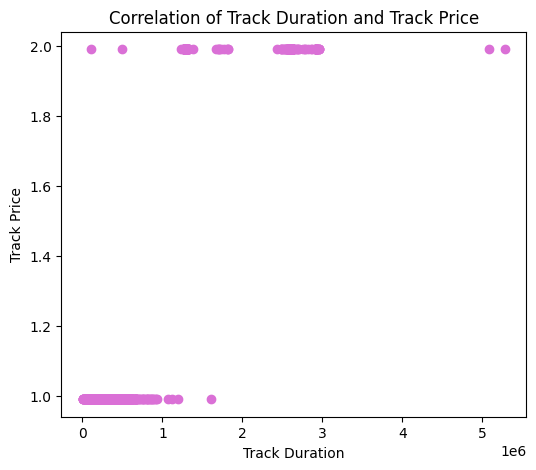

In [68]:
plt.figure(figsize=(6,5))
plt.scatter(track['Milliseconds'], track['UnitPrice'], color='orchid')
plt.xlabel("Track Duration")
plt.ylabel("Track Price")
plt.title("Correlation of Track Duration and Track Price")

plt.show()

For checking **Non-Normal** and **Numerical** variables, I used **Spearman Correlation Coefficient**.

In [43]:
spearman_corr_track_duration_price, p_value_track_duration_price = stats.spearmanr(track['Milliseconds'], track['UnitPrice'])
print(f"Spearman Correlation Coefficient: {spearman_corr_track_duration_price}, p-value: {p_value_track_duration_price}")

Spearman Correlation Coefficient: 0.4099206080846446, p-value: 4.576036687486155e-142


In [44]:
alpha = 0.05
if p_value_track_duration_price < alpha:
    print("The track duration and price are dependent.")
    if abs(spearman_corr_track_duration_price) >= 0.5:
        print("There is a large dependency between duration and price of each track.")
    elif abs(spearman_corr_track_duration_price) >= 0.3:
        print("There is a medium dependency between duration and price of each track.")
    else:
        print("There is a small dependency between duration and price of each track.")
else:
    print("The track duration and price are independent.")

The track duration and price are dependent.
There is a medium dependency between duration and price of each track.


### 7-4) Check the dependency of Genres and Media Types.

Media Type and Genre are two **Categorical** variables so I will use **Chi-Square Hypothesis Test**.

In [45]:
# Contingency table of Genre and Media Type
contingency_table_genre_mediatype = pd.crosstab(genre_merged_track['GenreId'], genre_merged_track['MediaTypeId'])

# Hypothesis Test: Association between Genre and Media Type
# Null hypothesis: There is no significant association between Genre and Media Type.
# Alternative hypothesis: There is a significant association between Genre and Media Type.

chi2_statistic_genre_mediatype, p_value_genre_mediatype, _ , _ = stats.chi2_contingency(contingency_table_genre_mediatype)
print(f"Chi-square statistic: {chi2_statistic_genre_mediatype}, p-value: {p_value_genre_mediatype}")

alpha = 0.05
if p_value_genre_mediatype < alpha:
    print("Reject the null hypothesis. There is a significant association between Genre and Media Type.")
else:
    print("Fail to reject the null hypothesis. There is no significant association between Genre and Media Type.")

Chi-square statistic: 5650.1804373219775, p-value: 0.0
Reject the null hypothesis. There is a significant association between Genre and Media Type.


### 7-5) Check the dependency of the Customer's Total spent and their Country.

Customer's Total spent and the Country are **Numerical** and **Categorical** variables so I will use **Kruskal-Wallis Hypothesis Test**.

In [46]:
# Merge customer and invoice data
customer_merged_invoice = pd.merge(customer, invoice)

grouped_data_country_total = customer_merged_invoice.groupby('Country')['Total'].apply(list)
groups_country_total = grouped_data_country_total.tolist()

# Hypothesis Test: Association between Total spending of customers and countries
# Null hypothesis: There is no significant difference in the Total spending of customers across different countries.
# Alternative hypothesis: There is a significant difference in the Total spending of customers across different countries.

kruskal_statistic_country_total, p_value_country_total = stats.kruskal(*groups_country_total)
print(f"Statistic: {kruskal_statistic_country_total}, p-value: {p_value_country_total}")

alpha = 0.05
if p_value_country_total < alpha:
    print("Reject the null hypothesis. There is a significant difference in the Total spending of customers across different countries.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in the Total spending of customers across different countries.")

Statistic: 0.8839678174341911, p-value: 0.999999999999593
Fail to reject the null hypothesis. There is no significant difference in the Total spending of customers across different countries.


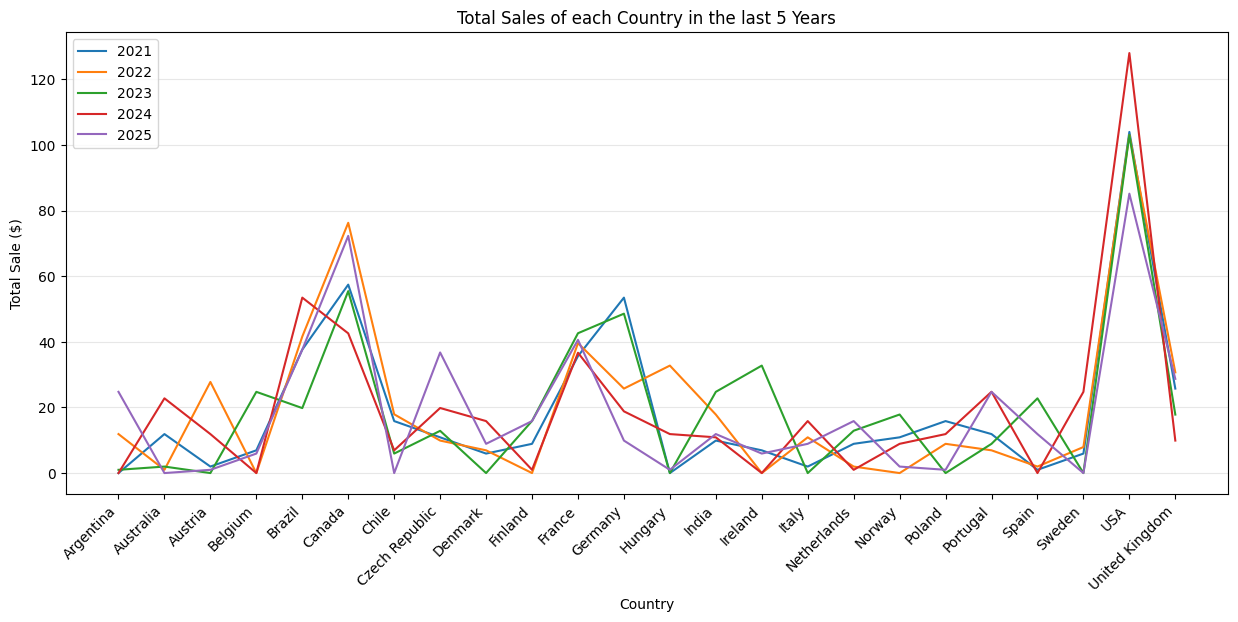

In [47]:
customer_merged_invoice['Year'] = customer_merged_invoice['InvoiceDate'].dt.year
country_total_year = customer_merged_invoice.groupby(['Country','Year'])['Total'].agg('sum').unstack().fillna(0)

plt.figure(figsize=(15,6))

labels = country_total_year.index
plt.plot(country_total_year)
plt.legend(country_total_year.columns)
plt.title("Total Sales of each Country in the last 5 Years")

plt.xlabel('Country')
plt.ylabel('Total Sale ($)')

plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', alpha=0.3)

plt.show()

The most of Sales happened in **USA** in the last 5 years.

### 7-6) Check the dependency of track Media Types and track Size.

Media type and track Size are **Categorical**  and **Numerical** variables so I will use **Kruskal-Wallis Hypothesis Test**.

In [48]:
grouped_data_mediatype_size = mediaType_merged_track.groupby('MediaTypeId')['Bytes'].apply(list)
groups_mediatype_size = grouped_data_mediatype_size.tolist()

# Hypothesis Test: Association between Track Size and Media Types
# Null hypothesis: There is no significant difference in track Size between different Media Types.
# Alternative hypothesis: There is a significant difference in track Size between different Media Types.

kruskal_statistic_mediatype_size, p_value_mediatype_size = stats.kruskal(*groups_mediatype_size)
print(f"Statistic: {kruskal_statistic_mediatype_size}, p-value: {p_value_mediatype_size}")

alpha = 0.05
if p_value_mediatype_size < alpha:
    print("Reject the null hypothesis. There is a significant difference in track Size between different Media Types.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in track Size between different Media Types.")

Statistic: 954.4896463010354, p-value: 2.599303948201249e-205
Reject the null hypothesis. There is a significant difference in track Size between different Media Types.


### 7-7) Check the dependency of Support Representative and Customer Total spent.

Support Representative and Customer Total spent are **categorical**  and **Numerical** variables so I will use **Kruskal-Wallis Hypothesis Test**.

In [49]:
grouped_data_supportrep_total = customer_merged_invoice.groupby('SupportRepId')['Total'].apply(list)
groups_supportrep_total = grouped_data_supportrep_total.tolist()

# Hypothesis Test: Association between customer Total spending and Support Representatives
# Null hypothesis: There is no significant difference in customer Total spending between different Support Representatives.
# Alternative hypothesis: There is a significant difference in customer Total spending between different Support Representatives.

kruskal_statistic_supportrep_total, p_value_supportrep_total = stats.kruskal(*groups_supportrep_total)

alpha = 0.05
if p_value_supportrep_total < alpha:
    print("Reject the null hypothesis. There is a significant difference in customer Total spending between different Support Representatives.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in customer Total spending between different Support Representatives.")

Fail to reject the null hypothesis. There is no significant difference in customer Total spending between different Support Representatives.


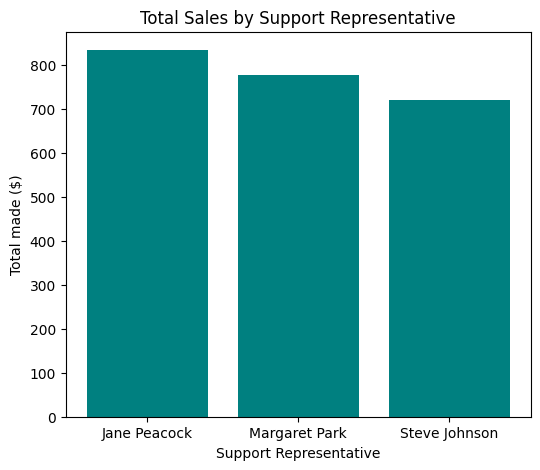

In [67]:
customer_merged_invoice_merged_employee = pd.merge(customer_merged_invoice, employee, left_on='SupportRepId', right_on='EmployeeId', suffixes=['_customer','_employee'])
support_rep_total_made = customer_merged_invoice_merged_employee.groupby(['SupportRepId','FullName'])['Total'].agg('sum').reset_index(name='Total')

plt.figure(figsize=(6,5))
plt.bar(support_rep_total_made['FullName'], support_rep_total_made['Total'], color='teal')
plt.title("Total Sales by Support Representative")
plt.xlabel("Support Representative")
plt.ylabel("Total made ($)")

plt.show()

## 8- Confidence Interval

### 8-1) Is the average Duration of Tracks in different genres the same? Calculate a 95% confidence interval for the average Duration of Tracks in each genre.

Genre and Track duration are **categorical**  and **Numerical** variables so I will use **Kruskal-Wallis Hypothesis Test**.

In [51]:
grouped_data_genre_track = track.groupby('GenreId')['Milliseconds'].apply(list)
groups_genre_track = grouped_data_genre_track.tolist()

# Hypothesis Test: Association between Track durations and Genres
# Null hypothesis: There is no significant difference in Track durations between different Genres.
# Alternative hypothesis: There is a significant difference in Track durations between different Genres.

kruskal_statistic_genre_track, p_value_genre_track = stats.kruskal(*groups_genre_track)

alpha = 0.05
if p_value_genre_track < alpha:
    print("Reject the null hypothesis. There is a significant difference in Track durations between different Genres.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in Track durations between different Genres.")

Reject the null hypothesis. There is a significant difference in Track durations between different Genres.


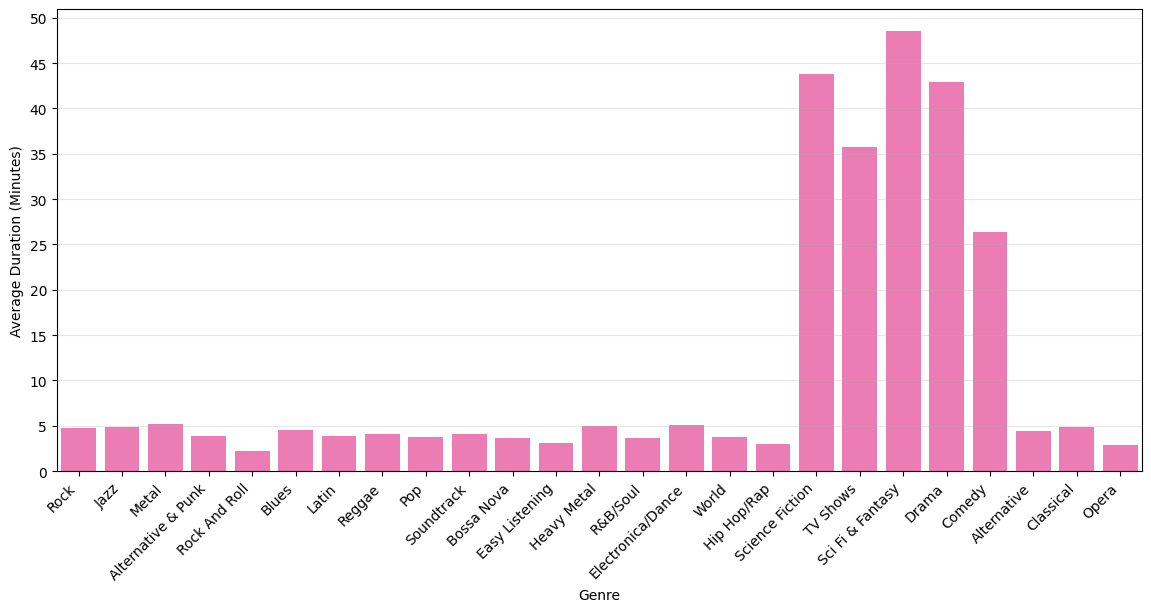

In [65]:
genre_average_duration = genre_merged_track.groupby(['GenreId','Name_genre'])['Milliseconds'].agg('mean')/60000
genre_average_duration = genre_average_duration.reset_index(name='Average')

plt.figure(figsize=(14,6))
labels = genre_average_duration['Name_genre'].to_list()
sns.barplot(genre_average_duration['Average'], color='hotpink')

plt.xticks(range(len(genre_average_duration)), labels=labels, rotation=45,  ha='right')
yticks = np.arange(0, 51, 5)
plt.yticks(yticks)

plt.xlabel("Genre")
plt.ylabel("Average Duration (Minutes)")

plt.grid(True, axis='y', alpha=0.3)
plt.show()

Most Genres have an average duration of less than 5 minutes, but 5 genres have an average duration of more than 25 minutes. Those genres are: **Science Fiction**, **TV Shows**, **Sci Fi & Fantasy**, **Drama** and **Comedy**.

For calculating **Confidence Intervals**, I defined the function below:

In [53]:
def confidence_interval(df, filter_col, filter_value, target_col, confidence_level):

    
    sample = df[df[filter_col] == filter_value][target_col]
    sample_mean = np.mean(sample)
    sample_std = np.std(sample, ddof=1)
    n = len(sample)
    z = stats.norm.ppf(1 - (1 - confidence_level) / 2)
    standard_error = sample_std / np.sqrt(n)

    lower_bound = sample_mean - z * standard_error
    upper_bound = sample_mean + z * standard_error
    CI =(lower_bound.round(2), upper_bound.round(2))
    return CI

In [54]:
ci_table_genre_duration = []

# Calculating the confidence interval of each Genre's Duration
for GenreId in genre_merged_track['GenreId'].unique():
    genre_name = genre_merged_track.loc[genre_merged_track['GenreId'] == GenreId, 'Name_genre'].unique()[0]
    ci = confidence_interval(genre_merged_track, 'GenreId', GenreId, 'Milliseconds', 0.95)

    # Convert confidence interval from milliseconds to minutes
    lower_bound_minute = ci[0] / 60000
    upper_bound_minute = ci[1] / 60000
    ci_table_genre_duration.append({'GenreId': GenreId, 'Genre': genre_name, 'Lower Bound (minute)': lower_bound_minute, 'Upper Bound (minute)': upper_bound_minute})
    

ci_df_genre_duration = pd.DataFrame(ci_table_genre_duration)
print("This is the confidence interval (95%) of track durations in every genre:")
ci_df_genre_duration

This is the confidence interval (95%) of track durations in every genre:


,GenreId,Genre,Lower Bound (minute),Upper Bound (minute)
0,1,Rock,4.616825,4.846843
1,2,Jazz,4.492649,5.232531
2,3,Metal,4.980254,5.344728
3,4,Alternative & Punk,3.764771,4.047024
4,5,Rock And Roll,2.050949,2.437168
5,6,Blues,4.153880,4.858112
6,7,Latin,3.789711,3.972265
7,8,Reggae,3.937516,4.301743
8,9,Pop,3.440517,4.193953
9,10,Soundtrack,3.763411,4.382285


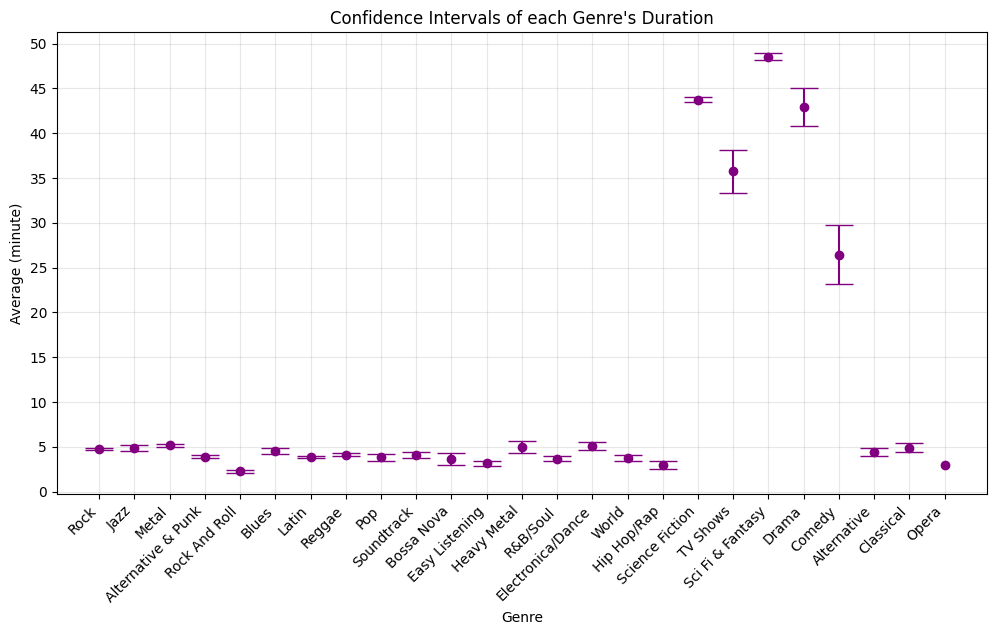

In [55]:
ci_df_genre_duration['Average'] = genre_average_duration['Average']

ci_df_genre_duration['Lower Error'] = ci_df_genre_duration['Average'] - ci_df_genre_duration['Lower Bound (minute)']
ci_df_genre_duration['Upper Error'] = ci_df_genre_duration['Upper Bound (minute)'] - ci_df_genre_duration['Average']

yerr_genre_duration = [ci_df_genre_duration['Lower Error'], ci_df_genre_duration['Upper Error']]
plt.figure(figsize=(12, 6))

plt.errorbar(ci_df_genre_duration['Genre'], ci_df_genre_duration['Average'], yerr=yerr_genre_duration, fmt="o", capsize=10, color='purple')
plt.title("Confidence Intervals of each Genre's Duration")

plt.xticks(rotation=45, ha='right')
yticks = np.arange(0, 51, 5)
plt.yticks(yticks)

plt.xlabel('Genre')
plt.ylabel('Average (minute)')
plt.grid(True, alpha=0.3)

plt.show()

### 8-2) What is the average sales in different countries? Calculate the 95% confidence interval for the average sales in each country.

In [57]:
average_sales_country = customer_merged_invoice.groupby('Country')['Total'].agg('mean').reset_index(name='Average ($)')
print("This is the Average Total Sales in countries of Chinook Database:")
average_sales_country

This is the Average Total Sales in countries of Chinook Database:


,Country,Average ($)
0,Argentina,5.374286
1,Australia,5.374286
2,Austria,6.088571
3,Belgium,5.374286
4,Brazil,5.431429
5,Canada,5.427857
6,Chile,6.660000
7,Czech Republic,6.445714
8,Denmark,5.374286
9,Finland,5.945714


In [58]:
ci_table_country_sales = []

# Calculating the confidence interval of each Country's Total
for Country in customer_merged_invoice['Country'].unique():
    ci = confidence_interval(customer_merged_invoice, 'Country', Country, 'Total', 0.95)

    lower_bound = ci[0]
    upper_bound = ci[1]
    ci_table_country_sales.append({'Country': Country, 'Lower Bound ($)': lower_bound, 'Upper Bound ($)': upper_bound})

ci_df_country_sales = pd.DataFrame(ci_table_country_sales)
print("This is the confidence interval (95%) of total sales in every country:")
ci_df_country_sales

This is the confidence interval (95%) of total sales in every country:


,Country,Lower Bound ($),Upper Bound ($)
0,Brazil,4.00,6.86
1,Germany,3.85,7.33
2,Canada,4.29,6.56
3,Norway,1.76,9.56
4,Czech Republic,2.74,10.15
5,Austria,1.45,10.73
6,Belgium,1.94,8.81
7,Denmark,1.94,8.81
8,USA,4.75,6.75
9,Portugal,3.10,7.93


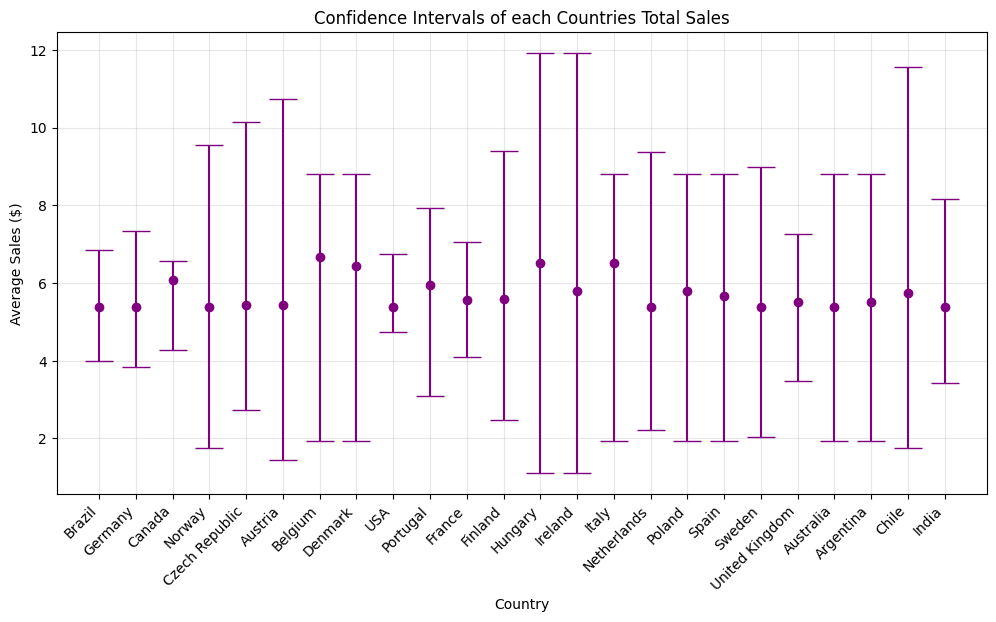

In [59]:
ci_df_country_sales['Average'] = average_sales_country['Average ($)']

ci_df_country_sales['Lower Error'] = ci_df_country_sales['Average'] - ci_df_country_sales['Lower Bound ($)']
ci_df_country_sales['Upper Error'] = ci_df_country_sales['Upper Bound ($)'] - ci_df_country_sales['Average']

yerr_country_sales = [ci_df_country_sales['Lower Error'], ci_df_country_sales['Upper Error']]
plt.figure(figsize=(12, 6))

plt.errorbar(ci_df_country_sales['Country'], ci_df_country_sales['Average'], yerr=yerr_country_sales, fmt='o', capsize=10, color='purple')
plt.title('Confidence Intervals of each Countries Total Sales')
plt.xlabel('Country')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Sales ($)')

plt.grid(True, alpha=0.3)

plt.show()

### 8-3) What is the average number of tracks purchased by each customer? Calculate the 95% confidence interval for the average number of tracks purchased by each customer.

In [60]:
invoice_merged_invoiceline = pd.merge(invoice, invoiceLine)
average_tracks_per_customer = invoice_merged_invoiceline.groupby('CustomerId')['Quantity'].agg('count').mean()
print(f"The average number of tracks purchased by each customer is {round(average_tracks_per_customer)} tracks.")

The average number of tracks purchased by each customer is 38 tracks.


This is the confidence interval (95%) of average number of tracks purchased by each customer: (np.float64(37.9), np.float64(38.03))


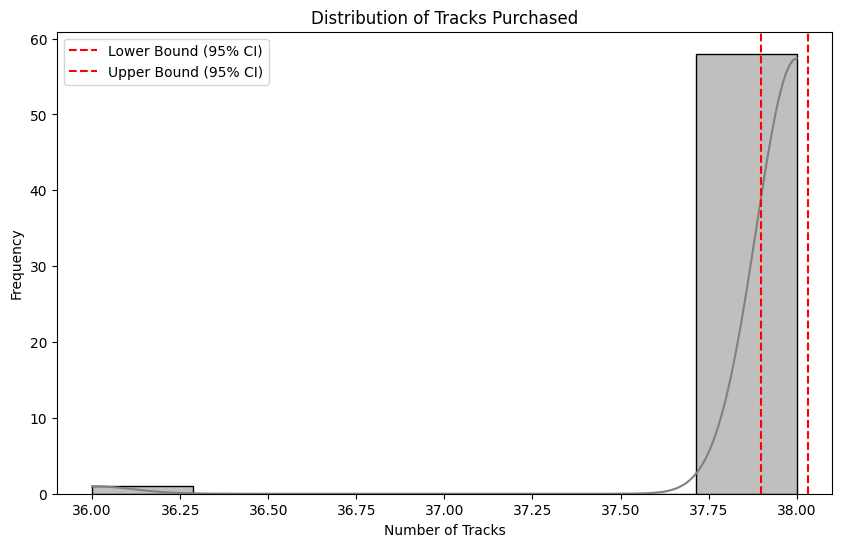

In [63]:
count_tracks_per_customer = invoice_merged_invoiceline.groupby('CustomerId')['TrackId'].agg('count').reset_index(name='Count')
sample_mean = np.mean(count_tracks_per_customer['Count'])
sample_std = np.std(count_tracks_per_customer['Count'], ddof=1)
n = len(count_tracks_per_customer['Count'])

confidence_level = 0.95
z = stats.norm.ppf(1 - (1 - confidence_level) / 2)
standard_error = sample_std / np.sqrt(n)

lower_bound = sample_mean - z * standard_error
upper_bound = sample_mean + z * standard_error
confidence_interval = (round(lower_bound, 2), round(upper_bound, 2))
print(f"This is the confidence interval (95%) of average number of tracks purchased by each customer: {confidence_interval}")

plt.figure(figsize=(10, 6))
sns.histplot(count_tracks_per_customer['Count'], kde=True, color='gray')
plt.axvline(x=lower_bound, color='red', linestyle='--', label='Lower Bound (95% CI)')
plt.axvline(x=upper_bound, color='red', linestyle='--', label='Upper Bound (95% CI)')
plt.title('Distribution of Tracks Purchased')
plt.xlabel('Number of Tracks')
plt.ylabel('Frequency')
plt.legend()
plt.show()